In [1]:
import os
import PyPDF2
import re
import psycopg2
import sys
import datetime

def walk_dir(dir,fileinfo,topdown=True):
    for root, dirs, files in os.walk(dir, topdown):
        for name in files:
            #print(os.path.join(name))
            fileinfo.write(os.path.join(root,name) + '\n')
        #for name in dirs:
            #print(os.path.join(name))
            #fileinfo.write('  ' + os.path.join(root,name) + '\n')

def parse(directory,cur):
    r = ""
    start_time=""
    end_time=""
    pdfFileObj = open(directory, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    num_pages = pdfReader.numPages
    for i in range(num_pages):
        pageObj = pdfReader.getPage(i)
        text = pageObj.extractText()

        text = text.replace("\n","")
        text = text.replace("Œ","-")
        text = text.replace("™","'")
        text = text.replace("˚","ffi")
        text = text.replace("˛","ff")
        text = text.replace("˜","fi")
        text = text.replace("˝","fl")

        content=text.split("Notice is hereby ")
        for j in range(len(content)):
            if j == 0:
                regions  = re.split("((?:[A-Z])(?:[A-Z|\.]+\s)+(?:REGION))", content[0])
            else:
                content=content[1].split("etc.)")
                regions  = re.split("((?:[A-Z])(?:[A-Z|\.]+\s)+(?:REGION))", content[1])

            for region in regions:
               
               county = ""

               if re.search('.+(REGION)',region):
                   #print("----------------------------")
                   #print(region.strip())
                   r = str(region)
                   #do_nothing=""
               else:
                  area_ints = region.split("AREA: ")
                  for area_int in area_ints:
                      areas = area_int.split("& adjacent customers.")
                      long_street = "" 
                      for area in areas:

                         if re.search('COUNTY',area):
                            #print("----------------------------")
                            #print(area)
                            county = str(area)
                            #do_nothing=""
                         else:

                             if not re.search('^\s*$',area):
                                #print("----------------------------")
                                data = area
                                a=""
                                date=""
                                time=""

                                if re.search('.*(?=DATE)',data):
                                    area_break = re.search('.*(?=DATE)',data).end()
                                    a = data[:area_break].strip()
                                    data = data[area_break+len("DATE: "):]

                                if re.search('.*(?=TIME)',area):
                                    date_break = re.search('.*(?=TIME)',data).end()
                                    date = data[:date_break].strip()
                                    data = data[date_break+len("TIME:"):]
                                    try:
                                        day_break=re.search('(?=[0-9]+)',date).end()
                                        date_=date[day_break:]
                                        day_break=re.search('[0-9]+',date_).end()
                                        day = date_[:day_break].strip()
                                        date_ = date_[day_break:]
                                        month_break=re.search('(?=[0-9]+)',date_).end()
                                        date_=date_[month_break:]
                                        month_break=re.search('[0-9]+',date_).end()
                                        month = date_[:month_break].strip()
                                        date_=date_[month_break:]
                                        year_break=re.search('(?=[0-9]+)',date_).end()
                                        date_=date_[year_break:]
                                        year_break=re.search('[0-9]+',date_).end()
                                        year = date_[:year_break].strip()
                                        date=year+'-'+month+'-'+day
                                    except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(date)
                                        print("----------------------------")

                                if re.search('(A\.M|P\.M).*(A\.M|P\.M(\.)?)',area):
                                    time_break = re.search('(A\.M|P\.M).*(A\.M|P\.M(\.)?)', data).end()
                                    times = data[:time_break].strip()
                                    data = data[time_break:]
                                    start_time=""
                                    end_time=""
                                    try:
                                        time=re.split("-|Š",times)
                                        start_time=time[0]
                                        end_time=time[1]
                                        
                                        hour_break=re.search('(?=[0-9]+)',start_time).end()
                                        start_time=start_time[hour_break:]
                                        hour_break=re.search('[0-9]+',start_time).end()
                                        hour=start_time[:hour_break].strip()
                                        start_time=start_time[hour_break+1:]
                                        minute_break=re.search('[0-9]+',start_time).end()
                                        minute=start_time[:minute_break].strip()
                                        start_time=start_time[minute_break:]
                                        time=hour+':'+minute+' '
                                        if re.search('A',start_time):
                                            time+='AM'
                                        else:
                                            time+='PM'
                                        start_time=time
                                        
                                        hour_break=re.search('(?=[0-9]+)',end_time).end()
                                        end_time=end_time[hour_break:]
                                        hour_break=re.search('[0-9]+',end_time).end()
                                        hour=end_time[:hour_break].strip()
                                        end_time=end_time[hour_break+1:]
                                        minute_break=re.search('[0-9]+',end_time).end()
                                        minute=end_time[:minute_break].strip()
                                        end_time=end_time[minute_break:]
                                        time=hour+':'+minute+' '
                                        if re.search('A',end_time):
                                            time+='AM'
                                        else:
                                            time+='PM'
                                        end_time=time
                                        
                                    except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(times)
                                        print("----------------------------")

                                if re.search('customers.',data):
                                    ending_break = re.search('customers.',data).end()
                                    data = data[:ending_break-len(" & adjacent customers.")]

                                #print(a + " : " + date + " : " + times)
                                sub_locs = data.split(",")
                                for sub_loc in sub_locs:
                                  if re.search('\d+(st|nd|rd|th)$',sub_loc):
                                     long_street += sub_loc.strip()
                                     long_street += ", "
                                  else:
                                     place = long_street + sub_loc.strip()
                                     #print(place)
                                     place = place.replace("\ufb02","")
                                     place = place.replace("\ufb01","")
                                     place = place.replace("\u201a","")
                                     a = a.replace("\xc1","")
                                     #outcome.write(county + '_' + r + '_' + a + '_' + place + '\n')
                                     
                                     list = []
                                     list.append(date)
                                     list.append(start_time)
                                     list.append(end_time)
                                     list.append(county)
                                     list.append(r)
                                     list.append(a)
                                     list.append(place)
                                     #print(list[0])
                                     for j in range(len(list)):
                                         if list[j]=="":
                                            list[j]=None
                                     crap = str(county + '_' + r + '_' + a + '_' + place)
                                     list.append(crap)
                                        
                                     length=""
                                     try:
                                         date_time=date+" "+start_time
                                         start=datetime.datetime.strptime(date_time,"%Y-%m-%d %I:%M %p")
                                         date_time=date+" "+end_time
                                         end=datetime.datetime.strptime(date_time,"%Y-%m-%d %I:%M %p")
                                         length=end-start
                                     except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(list)
                                        print("----------------------------")
                                     list.append(length)
                                     try:
                                         cur.execute("INSERT INTO outages (date,start_time,end_time,county,region,area,place,c_r_a_p,length)\
                                         VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)",\
                                        (list[0],list[1],list[2],list[3],list[4],list[5],list[6],list[7],list[8]))
                                     except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(list)
                                        print("----------------------------")
                                     long_street = ""
    pdfFileObj.close()
                                    
dir = r'C:\GridWatch\Parsing service interruptions\test' #dir of folder
fileinfo = open('C:\\GridWatch\\Parsing service interruptions\\test2.txt','w')
walk_dir(dir,fileinfo)
fileinfo.close()

f = open('C:\\GridWatch\\Parsing service interruptions\\test2.txt','r')
#o = open('C:\\GridWatch\\Parsing service interruptions\\list1.txt','w')
#con = psycopg2.connect(database='outage_map', user='postgres') 
con = psycopg2.connect(database='capstone', user='capstone', password='capstone', host='141.212.11.206', port='5432')
con.autocommit = True
cur = con.cursor()
cur.execute("DROP TABLE IF EXISTS outages")
cur.execute("CREATE TABLE outages(index SERIAL PRIMARY KEY)")
cur.execute("ALTER TABLE outages ADD date date")
cur.execute("ALTER TABLE outages ADD start_time time")
cur.execute("ALTER TABLE outages ADD end_time time")
cur.execute("ALTER TABLE outages ADD county text")
cur.execute("ALTER TABLE outages ADD region text")
cur.execute("ALTER TABLE outages ADD area text")
cur.execute("ALTER TABLE outages ADD place text")
cur.execute("ALTER TABLE outages ADD c_r_a_p text")
cur.execute("ALTER TABLE outages ADD length interval")
for line in f:
    #print("----------------------------")
    directory = line.replace("\n","")
    #print(directory)
    parse(directory,cur)
f.close()
#o.close()
con.commit()
print("finish")

finish


In [1]:
import psycopg2
import sys
'''
cur.execute("SELECT * FROM outages")
rows = cur.fetchall()
for row in rows:
    print(row)
'''
con = psycopg2.connect(database='outage_map', user='postgres')
con.autocommit = True
cur = con.cursor()
cur.execute("SELECT MAX(index) FROM outages")
count = cur.fetchall()
print(count[0])

(185081,)


In [4]:
cur.execute("SELECT c_r_a_p AS crap, COUNT(c_r_a_p) AS count FROM outages GROUP BY c_r_a_p HAVING COUNT(c_r_a_p)>=3 ORDER BY COUNT(c_r_a_p) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Fresha Dairy 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Gachoire 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Gatana 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Gathanje 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Githiga 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Githunguri Water Plant 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Ikinu 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Kahumira 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Kambaa 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Kamburu 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Kamuchege 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Ngere 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Nyanduma 29
_NAIROBI REGION_GITHIGA, GITWE, IKINU, PART OF GITHUNGURI_Part of Githunguri Town 2

In [8]:
cur.execute("SELECT length, COUNT(length) FROM outages GROUP BY length ORDER BY length DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

15:00:00 60
14:00:00 3
14:00:00 12
14:00:00 5
13:00:00 317
12:30:00 69
12:00:00 58
12:00:00 694
12:00:00 446
12:00:00 182
12:00:00 1042
11:30:00 17
11:30:00 360
11:00:00 123
11:00:00 1198
11:00:00 44
11:00:00 42
11:00:00 526
11:00:00 421
11:00:00 40
10:30:00 192
10:30:00 7
10:30:00 64
10:30:00 172
10:30:00 150
10:00:00 359
10:00:00 842
10:00:00 1848
10:00:00 425
10:00:00 1575
10:00:00 132
10:00:00 15
10:00:00 111
10:00:00 1003
10:00:00 97
10:00:00 218
9:45:00 10
9:30:00 62
9:30:00 177
9:30:00 604
9:30:00 352
9:30:00 64
9:30:00 35
9:30:00 680
9:30:00 268
9:15:00 22
9:00:00 504
9:00:00 5563
9:00:00 656
9:00:00 8093
9:00:00 1890
9:00:00 1335
9:00:00 565
9:00:00 714
9:00:00 502
9:00:00 1293
9:00:00 6779
9:00:00 16
9:00:00 5718
9:00:00 26
8:45:00 228
8:30:00 122
8:30:00 235
8:30:00 3357
8:30:00 7
8:30:00 1345
8:30:00 632
8:30:00 2894
8:30:00 17
8:30:00 6
8:30:00 55
8:30:00 90
8:30:00 72
8:30:00 700
8:15:00 15
8:15:00 26
8:00:00 10097
8:00:00 746
8:00:00 2916
8:00:00 847
8:00:00 2003
8:00:00

In [6]:
cur.execute("SELECT start_time, COUNT(start_time) FROM outages GROUP BY start_time ORDER BY COUNT(start_time) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

09:00:00 106418
08:00:00 43090
08:30:00 16306
07:00:00 8022
06:00:00 3744
07:30:00 2219
10:00:00 1605
09:30:00 1497
06:30:00 650
14:00:00 398
12:00:00 283
23:00:00 247
13:00:00 223
11:30:00 61
11:00:00 54
16:00:00 54
21:00:00 50
20:00:00 48
08:45:00 41
01:00:00 23
07:45:00 22
00:00:00 10
12:30:00 9
08:03:00 7


In [7]:
cur.execute("SELECT end_time, COUNT(end_time) FROM outages GROUP BY end_time ORDER BY COUNT(end_time) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

17:00:00 127404
16:00:00 19485
15:00:00 11200
18:00:00 8680
14:00:00 5810
16:30:00 3443
13:00:00 2121
12:00:00 1482
19:00:00 716
11:00:00 636
17:30:00 486
15:30:00 474
10:00:00 411
08:30:00 378
09:00:00 251
08:00:00 248
18:30:00 240
16:45:00 238
12:30:00 237
13:30:00 211
09:20:00 182
02:00:00 138
03:00:00 127
14:30:00 123
05:00:00 114
11:30:00 78
10:30:00 56
23:30:00 40
09:30:00 24
04:00:00 24
23:00:00 12
04:30:00 7
22:00:00 5


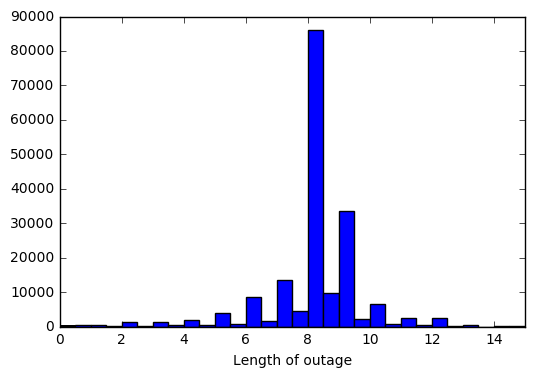

In [25]:
import matplotlib.pyplot as plt
import numpy as np
cur.execute("SELECT length FROM outages")
rows = cur.fetchall()

a=np.array([])
for row in rows:
    time_float = row[0].total_seconds() /3600
    a=np.insert(a,0,time_float)
plt.hist(a,bins=np.arange(0,15.5,0.5))
plt.xlim(0,15)
plt.xlabel('Length of outage')
plt.show()

In [30]:
cur.execute("SELECT DISTINCT region,COUNT(*) FROM outages GROUP BY region ORDER BY COUNT(*) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0],row[1])

NAIROBI REGION 53710
WEST REGION 36923
MT KENYA REGION 33118
COAST REGION 26016
MT. KENYA REGION 5553
NORTH EASTERN REGION 4744
NAIROBI SOUTH REGION 4527
CENTRAL RIFT REGION 4500
NAIROBI WEST REGION 3773
SOUTH NYANZA REGION 3467
NAIROBI NORTH REGION 2971
NORTH RIFT REGION 2657
WESTERN REGION 2334
KENYA REGION 490
WEST KENYA REGION 186
None 112
